# GAN MNIST

In [1]:
from sklearn.model_selection import train_test_split
import gc
from time import time
import datetime
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mlp
from torchinfo import summary
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets as dest
from torchvision import models as M
from torchvision import transforms
import torchvision.utils as vutils
from torch import optim
from torch import nn
import torchvision
from PIL import Image
from skimage import io
import cv2
import os
import re
import torch
import warnings
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
torch.backends.cudnn.benchmark = True
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


manualSeed = 1412
torch.manual_seed(manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)

![](https://www.researchgate.net/publication/333831200/figure/fig5/AS:782113389412353@1563481771648/GAN-framework-in-which-the-generator-and-discriminator-are-learned-during-the-training.png)

- Special crossEntropy
$$V(D,G)=\frac{1}{m}\sum_{i=1}^m[logD(x_i)+log(1-D(G(z_i)))]$$

>- For Discriminator
$$\begin{aligned}
Loss_D &= \frac{1}{m}\sum_{i=1}^m [logD(x_i) + log(1-D(G(z_i))) ] \\
&= \frac{1}{m}\sum_{i=1}^m [log1 + log(1-0)]\\
&= 0
\end{aligned}$$
    

>- For Generator
$$\begin{aligned}
Loss_G &= \frac{1}{m}\sum_{i=1}^m [CONSTANT + log(1-D(G(z_i))] \\  
- The part deleted CONSTANT:\\  
&= \frac{1}{m}\sum_{i=1}^mlog(1-D(G(z_i))\\
\end{aligned}$$

$$\begin{aligned}
Loss_G &= \frac{1}{m}\sum_{i=1}^m [log(1-D(G(z_i))] \\
&= \frac{1}{m}\sum_{i=1}^m [log(1-1)]\\
&= -\infty
\end{aligned}$$

In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        """
        in_features: dim of real data and fake data
        """
        super().__init__()
        self.disc = nn.Sequential(nn.Linear(in_features, 128),
                                  nn.LeakyReLU(0.1),
                                  nn.Linear(128, 1),
                                  nn.Sigmoid()
                                  )

    def forward(self, data):
        """
        real data -> dx
        gz data -> dgz
        """
        return self.disc(data)


class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        """
        in_features: in_features in generator, input dim of z
        out_features: dim same as dim of real data
        """
        super().__init__()
        self.gen = nn.Sequential(nn.Linear(in_features, 256),
                                 nn.LeakyReLU(0.1),
                                 nn.Linear(256, out_features),
                                 nn.Tanh()
                                 )

    def forward(self, z):
        gz = self.gen(z)
        return gz

In [3]:
# check
z = torch.ones((10, 64))
gen = Generator(64, 784)
gen(z).shape

torch.Size([10, 784])

In [4]:
disc = Discriminator(784)
disc(gen(z)).shape

torch.Size([10, 1])

In [5]:
batch_size = 32
lr = 3e-4
num_epochs = 50
realdata_dim = 28*28*1
z_dim = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor()                                # ,transforms.Normalize((0.1307),(0.3081))])
                                , transforms.Normalize((0.5), (0.5))])
dataset = dest.MNIST(root=r"E:\data\MNIST\MNIST",
                     transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


fixed_noise = torch.randn((batch_size, z_dim)).to(device)

gen = Generator(in_features=z_dim, out_features=realdata_dim).to(device)
disc = Discriminator(in_features=realdata_dim).to(device)

optim_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
optim_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))

criterion = nn.BCELoss(reduction="mean")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting E:\data\MNIST\MNIST\MNIST\raw\train-images-idx3-ubyte.gz to E:\data\MNIST\MNIST\MNIST\raw


  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting E:\data\MNIST\MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to E:\data\MNIST\MNIST\MNIST\raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting E:\data\MNIST\MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to E:\data\MNIST\MNIST\MNIST\raw


  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting E:\data\MNIST\MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to E:\data\MNIST\MNIST\MNIST\raw
Processing...
Done!


In [6]:
len(dataloader)

1875

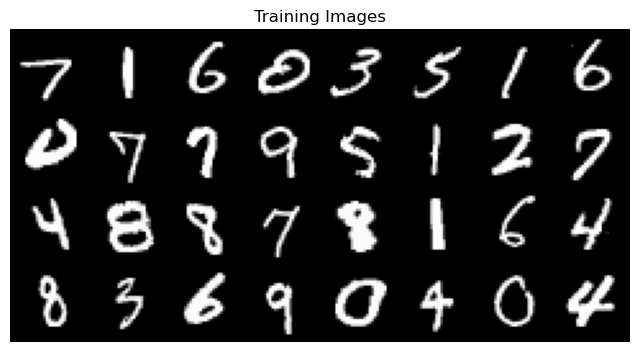

In [7]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[
           :32], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [8]:
img_list = []
G_losses = []
D_real_loss = []
D_fake_loss = []
D_losses = []
iters = 0

In [9]:
for epoch in range(num_epochs):
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.view(-1, 784).to(device)
        batch_size = x.shape[0]

        dx = disc(x).view(-1)
        loss_real = criterion(dx, torch.ones_like(dx))
        loss_real.backward()
        D_x = dx.mean().item()

        noise = torch.randn((batch_size, z_dim)).to(device)
        gz = gen(noise)
        dgz1 = disc(gz.detach())
        loss_fake = criterion(dgz1, torch.zeros_like(dgz1))
        loss_fake.backward()
        D_G_z1 = dgz1.mean().item()

        errorD = (loss_real + loss_fake)/2
        optim_disc.step()
        disc.zero_grad()

        dgz2 = disc(gz)
        errorG = criterion(dgz2, torch.ones_like(dgz2))
        errorG.backward()
        optim_gen.step()
        gen.zero_grad()
        D_G_z2 = dgz2.mean().item()

        if batch_idx % 500 == 0 or batch_idx == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' %
                  (epoch+1, num_epochs, batch_idx, len(dataloader), errorD.item(), errorG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errorG.item())
        D_real_loss.append(loss_real.item())
        D_fake_loss.append(loss_fake.item())
        D_losses.append(errorD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).cpu().detach()
            print("fake data saved")
            img_list.append(fake.view(-1, 1, 28, 28))

        iters += 1

[1/50][0/1875]	Loss_D: 0.7293	Loss_G: 0.6626	D(x): 0.4844	D(G(z)): 0.5192 / 0.5156
fake data saved
[1/50][500/1875]	Loss_D: 0.6708	Loss_G: 0.5253	D(x): 0.7526	D(G(z)): 0.6485 / 0.5927
fake data saved
[1/50][1000/1875]	Loss_D: 0.7254	Loss_G: 0.4441	D(x): 0.7273	D(G(z)): 0.6696 / 0.6442
fake data saved
[1/50][1500/1875]	Loss_D: 0.6673	Loss_G: 0.4537	D(x): 0.7718	D(G(z)): 0.6551 / 0.6363
fake data saved
[2/50][0/1875]	Loss_D: 0.5458	Loss_G: 0.5942	D(x): 0.8377	D(G(z)): 0.5908 / 0.5576
fake data saved
[2/50][500/1875]	Loss_D: 0.7007	Loss_G: 0.4897	D(x): 0.7521	D(G(z)): 0.6637 / 0.6157
fake data saved
[2/50][1000/1875]	Loss_D: 0.4629	Loss_G: 0.6915	D(x): 0.9093	D(G(z)): 0.5568 / 0.5064
fake data saved
[2/50][1500/1875]	Loss_D: 0.6342	Loss_G: 0.4967	D(x): 0.7856	D(G(z)): 0.6342 / 0.6113
fake data saved
[3/50][0/1875]	Loss_D: 0.6729	Loss_G: 0.4939	D(x): 0.7429	D(G(z)): 0.6426 / 0.6130
fake data saved
[3/50][500/1875]	Loss_D: 0.5378	Loss_G: 0.6316	D(x): 0.8128	D(G(z)): 0.5690 / 0.5359
fake dat

[21/50][1000/1875]	Loss_D: 0.7445	Loss_G: 0.4809	D(x): 0.7198	D(G(z)): 0.6629 / 0.6270
fake data saved
[21/50][1500/1875]	Loss_D: 0.6574	Loss_G: 0.5902	D(x): 0.6964	D(G(z)): 0.5995 / 0.5607
fake data saved
[22/50][0/1875]	Loss_D: 0.6385	Loss_G: 0.5447	D(x): 0.7154	D(G(z)): 0.5973 / 0.5854
fake data saved
[22/50][500/1875]	Loss_D: 0.6677	Loss_G: 0.4018	D(x): 0.7685	D(G(z)): 0.6394 / 0.6750
fake data saved
[22/50][1000/1875]	Loss_D: 0.7280	Loss_G: 0.4600	D(x): 0.7223	D(G(z)): 0.6577 / 0.6392
fake data saved
[22/50][1500/1875]	Loss_D: 0.6727	Loss_G: 0.4754	D(x): 0.7146	D(G(z)): 0.6197 / 0.6275
fake data saved
[23/50][0/1875]	Loss_D: 0.7383	Loss_G: 0.4635	D(x): 0.7068	D(G(z)): 0.6672 / 0.6318
fake data saved
[23/50][500/1875]	Loss_D: 0.7308	Loss_G: 0.4317	D(x): 0.6269	D(G(z)): 0.6164 / 0.6529
fake data saved
[23/50][1000/1875]	Loss_D: 0.7252	Loss_G: 0.4221	D(x): 0.7560	D(G(z)): 0.6760 / 0.6612
fake data saved
[23/50][1500/1875]	Loss_D: 0.7807	Loss_G: 0.4382	D(x): 0.7734	D(G(z)): 0.7152 / 0

[42/50][0/1875]	Loss_D: 0.7260	Loss_G: 0.4252	D(x): 0.6867	D(G(z)): 0.6505 / 0.6571
fake data saved
[42/50][500/1875]	Loss_D: 0.7209	Loss_G: 0.4500	D(x): 0.6909	D(G(z)): 0.6485 / 0.6421
fake data saved
[42/50][1000/1875]	Loss_D: 0.7292	Loss_G: 0.4262	D(x): 0.7118	D(G(z)): 0.6662 / 0.6554
fake data saved
[42/50][1500/1875]	Loss_D: 0.6559	Loss_G: 0.5056	D(x): 0.7206	D(G(z)): 0.6177 / 0.6076
fake data saved
[43/50][0/1875]	Loss_D: 0.7265	Loss_G: 0.4171	D(x): 0.6928	D(G(z)): 0.6558 / 0.6615
fake data saved
[43/50][500/1875]	Loss_D: 0.6830	Loss_G: 0.5215	D(x): 0.6887	D(G(z)): 0.6203 / 0.5985
fake data saved
[43/50][1000/1875]	Loss_D: 0.7371	Loss_G: 0.4268	D(x): 0.7059	D(G(z)): 0.6656 / 0.6571
fake data saved
[43/50][1500/1875]	Loss_D: 0.7202	Loss_G: 0.4483	D(x): 0.6779	D(G(z)): 0.6432 / 0.6419
fake data saved
[44/50][0/1875]	Loss_D: 0.6686	Loss_G: 0.4900	D(x): 0.7263	D(G(z)): 0.6274 / 0.6184
fake data saved
[44/50][500/1875]	Loss_D: 0.7785	Loss_G: 0.3817	D(x): 0.6908	D(G(z)): 0.6878 / 0.685

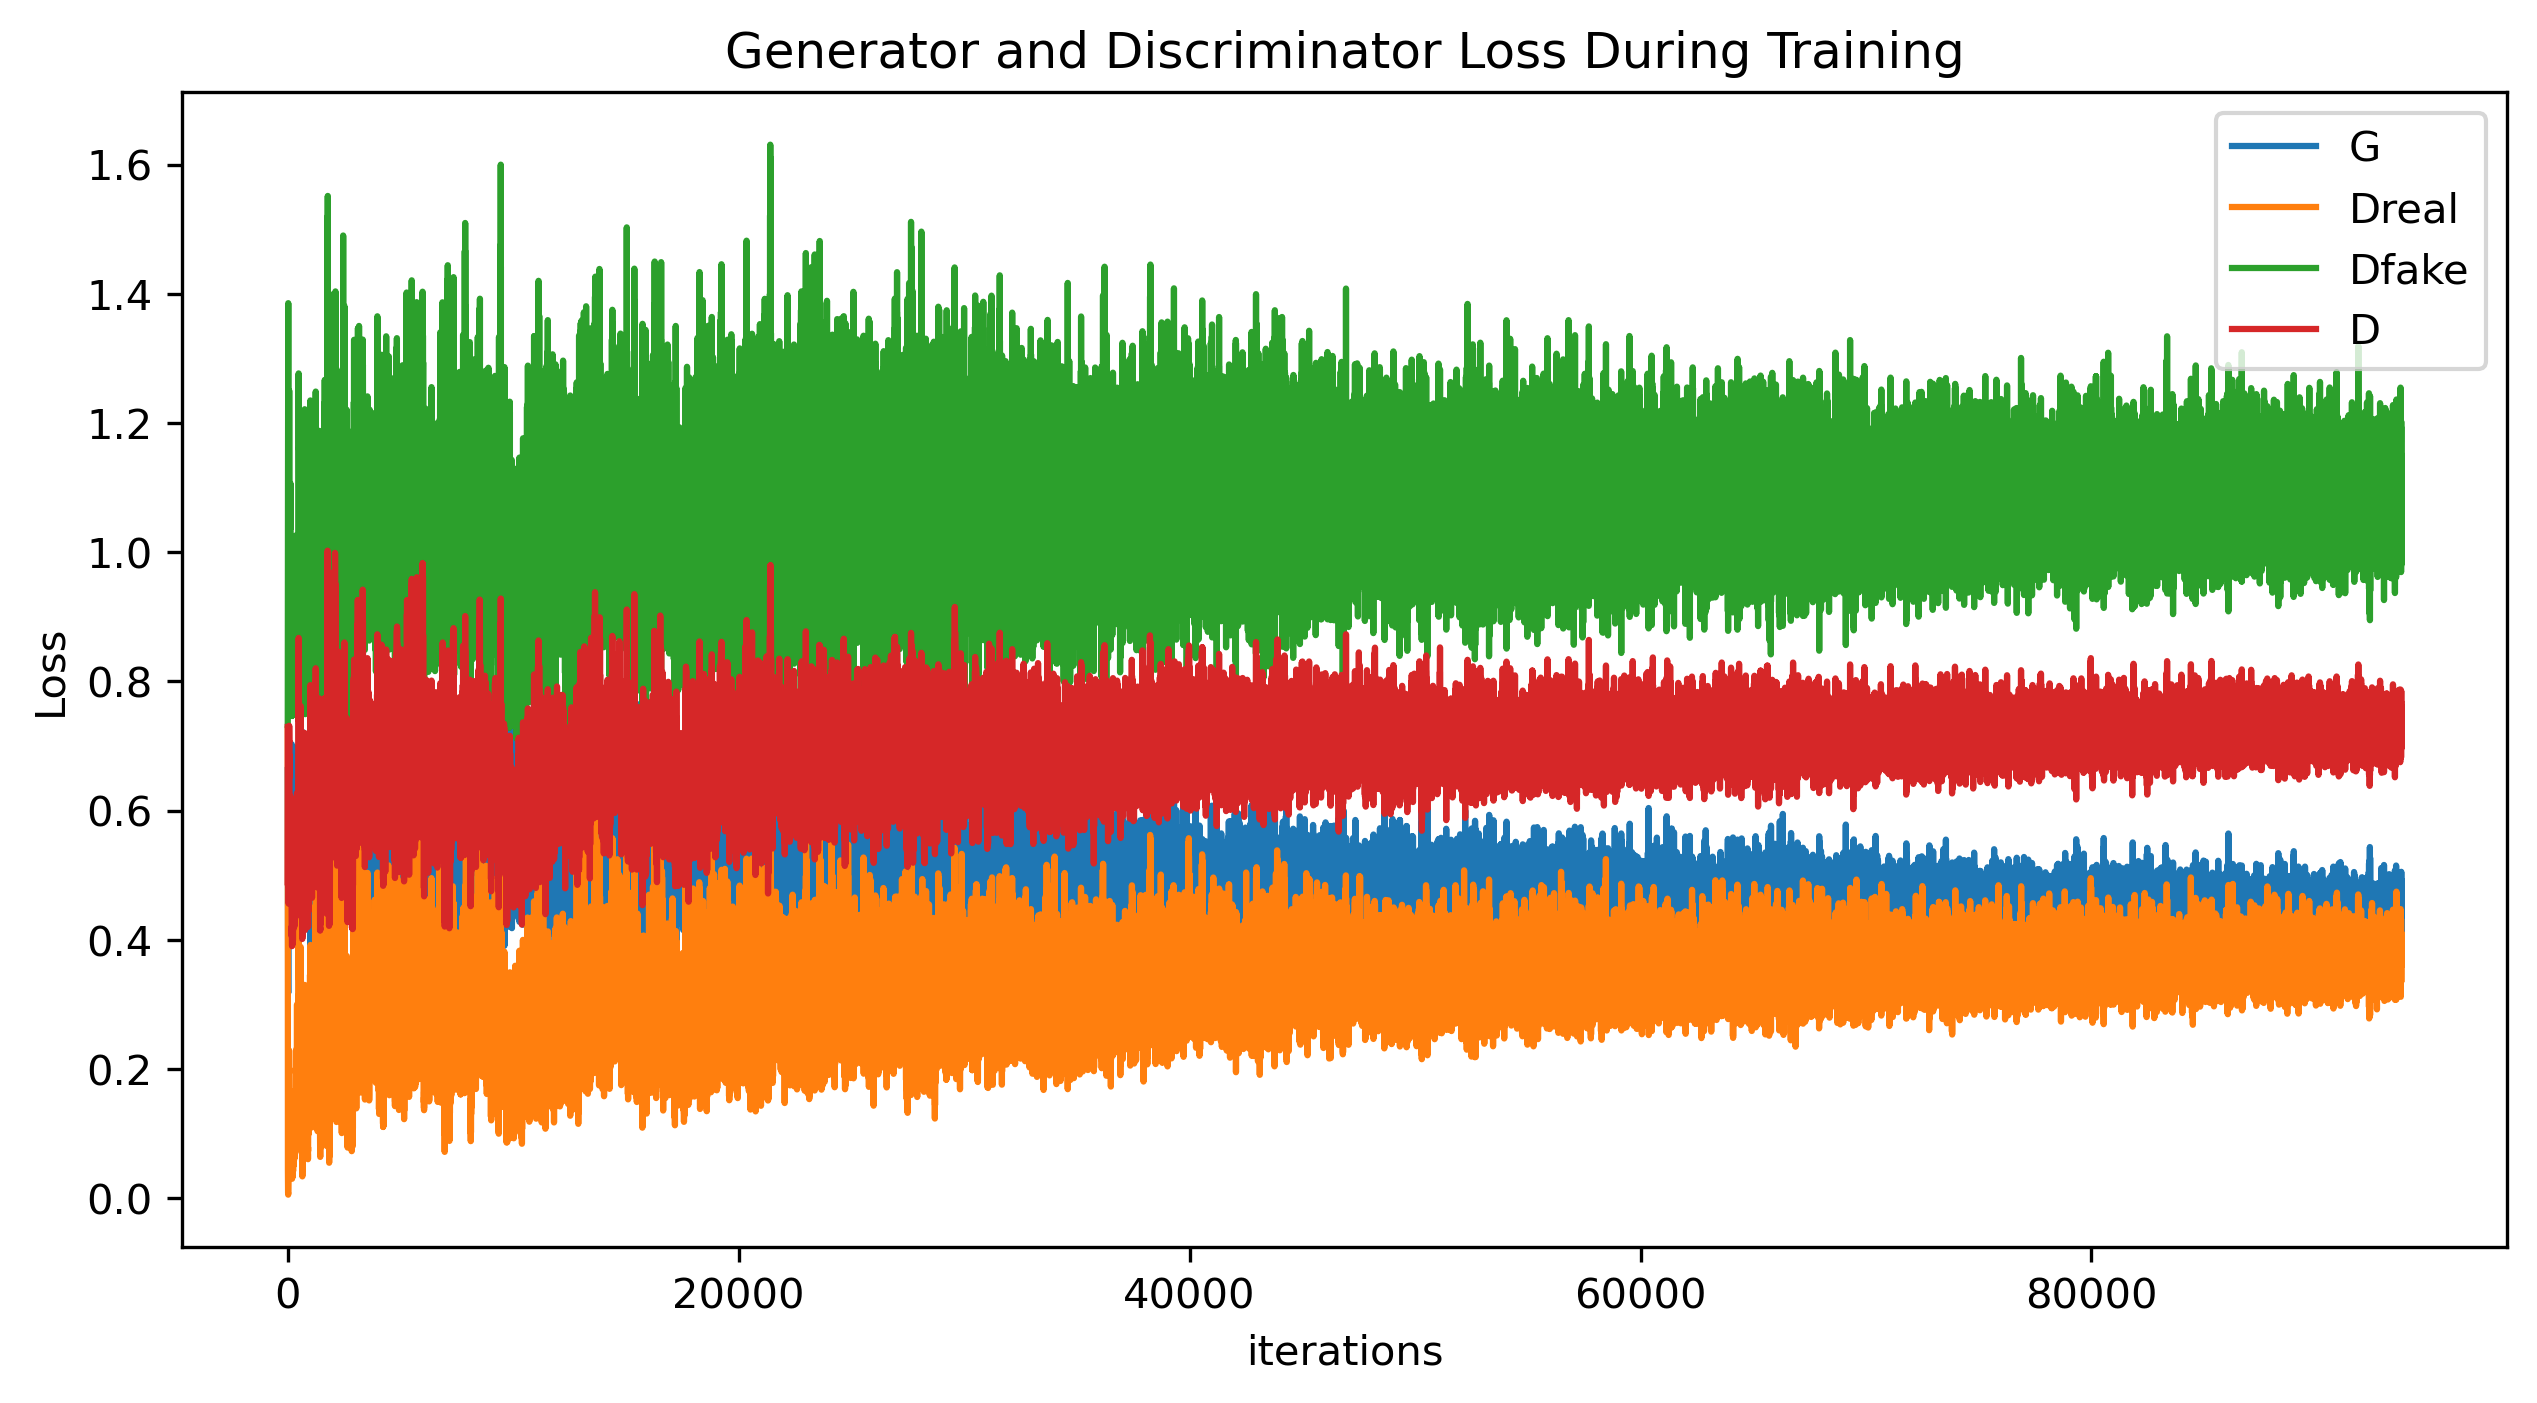

In [10]:
plt.figure(figsize=(10,5),dpi=300)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_real_loss,label="Dreal")
plt.plot(D_fake_loss,label="Dfake")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

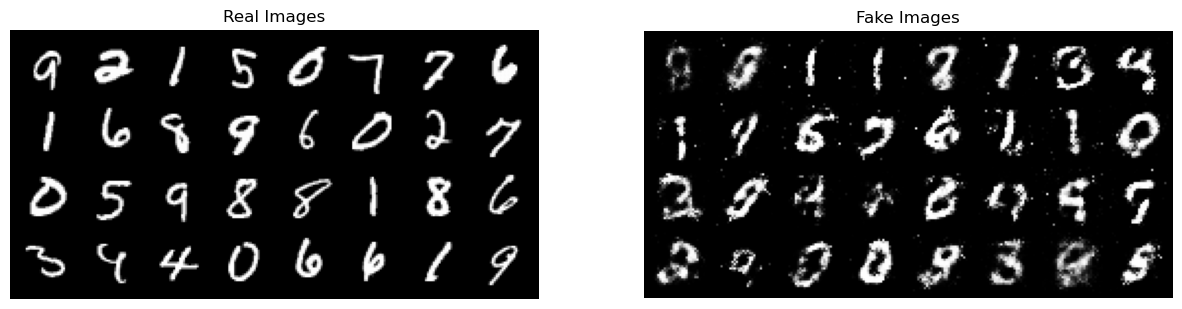

In [11]:
real_batch = next(iter(dataloader))

#原始图像中抽取一个batch
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

#绘制保存的最后一组生成图像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1].reshape(-1,1,28,28)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()